In [35]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
from cvxopt import matrix, solvers

In [4]:
from tqdm import tqdm

In [5]:
def is_valid_state(s):
    return (s>=0) and (s<100)

In [6]:
def is_valid_action(a):
    return (a>=0) and (a<4)

In [7]:
def get_row(s):
    return s%10

In [8]:
def get_column(s):
    return s//10

In [9]:
def is_internal_state(s):
    r=is_valid_state(s-1) and is_valid_state(s+1) and is_valid_state(s-10) and is_valid_state(s+10)
    return r and ((get_row(s-10)==get_row(s)) and (get_row(s+10)==get_row(s)) and (get_column(s-1)==get_column(s)) and (get_column(s+1)==get_column(s)))

In [10]:
#up=0, right=1, down=2, left=3

In [11]:
def state_after_action(s, a):
    if(not(is_valid_state(s))): raise NameError("Invalid state")
    if(not(is_valid_action(a))): raise NameError("Invalid action")
    s1=s
    if(a==0):
        if(is_valid_state(s-1) and (get_column(s-1)==get_column(s))): s1=s-1
    elif(a==1):
        if(is_valid_state(s+10) and (get_row(s+10)==get_row(s))): s1=s+10
    elif(a==2):
        if(is_valid_state(s+1) and (get_column(s+1)==get_column(s))): s1=s+1
    elif(a==3):
        if(is_valid_state(s-10) and (get_row(s-10)==get_row(s))): s1=s-10
    return s1

In [12]:
def evaluate_P(w=0.1):
    P=np.zeros((100,4,100))
    for s in range(100):
        for a in range(4):
            P[s][a][state_after_action(s,a)]+=1-w
            for a1 in range(4):
                P[s][a][state_after_action(s,a1)]+=w/4
    return P

In [13]:
P1=evaluate_P(0.1)

In [14]:
P2=evaluate_P(0.6)

In [15]:
R1=np.zeros((100,))

In [16]:
for i in [14,24,15,25,52,62,53,63,28,38,29,39]:
    R1[i]=-10
R1[99]=1

In [17]:
R2=np.zeros((100,))

In [18]:
for i in [41,42,43,44,45,46,51,61,62,63,73,83,84,85,86,87,77,67,68]:
    R2[i]=-100
R2[99]=10

In [19]:
print(pd.DataFrame(R1.reshape(10,10).transpose()))

     0     1     2     3    4     5     6    7    8    9
0  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
1  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
2  0.0   0.0   0.0   0.0  0.0 -10.0 -10.0  0.0  0.0  0.0
3  0.0   0.0   0.0   0.0  0.0 -10.0 -10.0  0.0  0.0  0.0
4  0.0 -10.0 -10.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
5  0.0 -10.0 -10.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
6  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
7  0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  0.0
8  0.0   0.0 -10.0 -10.0  0.0   0.0   0.0  0.0  0.0  0.0
9  0.0   0.0 -10.0 -10.0  0.0   0.0   0.0  0.0  0.0  1.0


In [20]:
print(pd.DataFrame(R2.reshape(10,10).transpose()))

     0    1    2    3      4      5      6      7      8     9
0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0   0.0
1  0.0  0.0  0.0  0.0 -100.0 -100.0 -100.0    0.0    0.0   0.0
2  0.0  0.0  0.0  0.0 -100.0    0.0 -100.0    0.0    0.0   0.0
3  0.0  0.0  0.0  0.0 -100.0    0.0 -100.0 -100.0 -100.0   0.0
4  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
5  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
6  0.0  0.0  0.0  0.0 -100.0    0.0    0.0    0.0 -100.0   0.0
7  0.0  0.0  0.0  0.0    0.0    0.0 -100.0 -100.0 -100.0   0.0
8  0.0  0.0  0.0  0.0    0.0    0.0 -100.0    0.0    0.0   0.0
9  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0  10.0


In [21]:
gamma=0.8
epsilon=0.01

In [22]:
def fast_value_iteration(P,R,epsilon=0.01,gamma=0.8):
    V=np.zeros((100,))
    delta=np.inf
    while delta>epsilon:
        v_next=np.amax(np.matmul(P,R+gamma*V), axis=1)
        delta=np.amax(np.abs(v_next-V))
        V=v_next
    policy=np.argmax(np.matmul(P,R+gamma*V), axis=1)
    return [V, policy]

In [23]:
def value_iteration(P,R,epsilon=0.01,gamma=0.8):
    V=np.zeros((100,1))
    policy=np.zeros((100,), dtype=int)
    delta=np.inf
    iter=0
    while delta>epsilon:
        delta=0
        for s in range(100):
            v_next=-np.inf
            for a in range(4):
                v_temp=0
                for s1 in range(100):
                    v_temp+=P[s][a][s1]*(R[s1]+gamma*V[s1])
                v_next = max(v_next, v_temp)
            delta=max(delta,np.abs(v_next-V[s]))
            V[s]=v_next
    for s in range(100):
        v_next=-np.inf
        opt_a=-1
        for a in range(4):
            v_temp=0
            for s1 in range(100):
                v_temp+=P[s][a][s1]*(R[s1]+gamma*V[s1])
            if(v_temp>v_next):
                opt_a=a
                v_next = v_temp
        policy[s]=opt_a
    return [V, policy]

In [24]:
def draw_heatmap(A,vmin=None, vmax=None, save=False,save_file_name=""):
    fig, ax = plt.subplots()
    if(vmin is None or vmax is None): im=ax.imshow(A.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest')
    else: im=ax.imshow(A.reshape(10,10).transpose(), cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.grid(color='k', linewidth=0.1)
    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    fig.colorbar(im)
    plt.show()
    if save: fig.savefig(save_file_name, dpi=600, bbox_inches='tight')

In [26]:
def draw_policy_grid(policy,save=False,save_file_name=""):
    policy_arrows=np.chararray((100,), unicode=True)
    for s in range(100):
        a=policy[s]
        if(a==0):
            policy_arrows[s]='↑'
        elif(a==1):
            policy_arrows[s]='→'
        elif(a==2):
            policy_arrows[s]='↓'
        elif(a==3):
            policy_arrows[s]='←'
    pa=policy_arrows.reshape(10,10)
    board = np.ones((10,10,3))
    fig, ax = plt.subplots()
    ax.imshow(board, interpolation='nearest', aspect='auto')
    ax.grid(color='k', linewidth=1)

    for i in range(10):
        for j in range(10):
            ax.text(i, j, pa[i][j], size=19, ha='center', va='center')

    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    ax.axis('image')

    plt.show()
    if save: fig.savefig(save_file_name, dpi=600, bbox_inches='tight')

In [27]:
R2max=np.amax(np.abs(R2))

In [28]:
def construct_lp_matrices(P,policy,lmda,Rmax):
    S=np.shape(P)[0]
    c=np.concatenate([np.ones((S,)), -lmda*np.ones((S,)), np.zeros((S,))])
    A=np.array([])
    nA=4
    
    Pa1=np.zeros((S,S))
    Pas=np.zeros((3,S,S))
    
    for s in range(S):
        opt_a=policy[s]
        Pa1[s,:]=P[s][opt_a]
        other_actions=np.setdiff1d(range(nA), opt_a)
        for i,a in enumerate(other_actions):
            Pas[i,s,:]=P[s][a]
            
    I, Z=np.eye(S), np.zeros((S,S))
    for i in range(nA-1):
        Pa=Pas[i]
        temp=np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))
        temp=np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))))
        if (A.shape[0]==0): A=temp
        else: A=np.vstack((temp, A))
            
    A=np.vstack((A, np.hstack((Z, -I, I))))
    A=np.vstack((A, np.hstack((Z, -I, -I))))
    A=np.vstack((A, np.hstack((Z, Z, I))))
    A=np.vstack((A, np.hstack((Z, Z, -I))))
    b=np.concatenate([np.zeros((2*(nA-1)*S+2*S,)), Rmax*np.ones((2*S,))])
    return [c,A,b]

In [29]:
def solve_irl(P,policy,Rmax,lmda=None):
    if lmda is None: raise NameError("Please specify lambda")
    solvers.options['show_progress']=False
    c,A,b=construct_lp_matrices(P,policy,lmda,Rmax)
    solution=solvers.lp(-matrix(c.transpose()),matrix(A),matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [30]:
def calc_accuracy_over_lmdas(P,target_policy,Rmax,lmdas,epsilon=0.01):
    accuracy=np.zeros_like(lmdas)
    for i,lmda in enumerate(tqdm(lmdas)):
        R_predicted=solve_irl(P,target_policy,Rmax,lmda)
        V,predicted_policy=fast_value_iteration(P,R_predicted,epsilon)
        accuracy[i]=(predicted_policy==target_policy).sum()/100
    return accuracy

### Q18

In [32]:
V2, policy2=fast_value_iteration(P1,R2)

In [33]:
lmdas=np.linspace(0,5,500)
accuracy=calc_accuracy_over_lmdas(P1,policy2,R2max,lmdas)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.48it/s]


Text(0, 0.5, 'Accuracy$=\\sum_{s\\in \\mathcal{S}}\\frac{m(s)}{|\\mathcal{S}|}$')

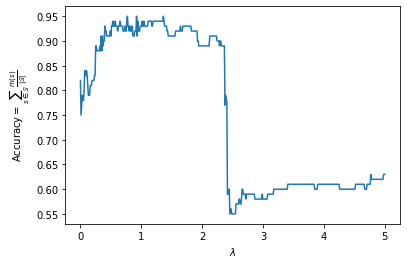

In [36]:
plt.plot(lmdas,accuracy)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Accuracy$=\sum_{s\in \mathcal{S}}\frac{m(s)}{|\mathcal{S}|}$')
#plt.savefig('plots/Q18.png', dpi=600, bbox_inches='tight')

### Q19

In [37]:
lmda_max_2=lmdas[np.argmax(accuracy)]

In [38]:
print(lmda_max_2)

0.7715430861723447


Text(0, 0.5, 'Accuracy$=\\sum_{s\\in \\mathcal{S}}\\frac{m(s)}{|\\mathcal{S}|}$')

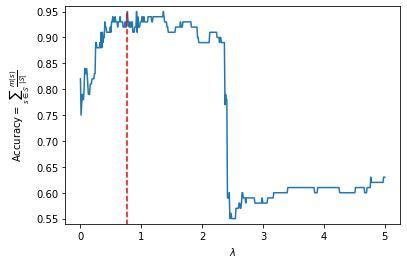

In [39]:
plt.plot(lmdas,accuracy)
plt.plot([lmda_max_2,lmda_max_2],[0,np.amax(accuracy)],'r--')
plt.ylim([0.54,0.96])
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Accuracy$=\sum_{s\in \mathcal{S}}\frac{m(s)}{|\mathcal{S}|}$')
plt.savefig('plots/Q19.png', dpi=600, bbox_inches='tight')

### Q20

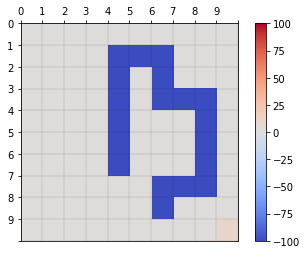

In [40]:
draw_heatmap(R2,save=False,save_file_name="plots/Q20_1.png", vmin=-100, vmax=100)

In [41]:
R_predicted=solve_irl(P1,policy2,R2max,lmda_max_2)

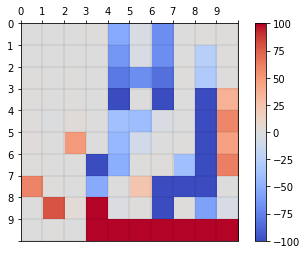

In [42]:
draw_heatmap(R_predicted,save=False,save_file_name="plots/Q20_2.png", vmin=-100, vmax=100)

### Q21

In [43]:
V_predicted,predicted_policy=fast_value_iteration(P1,R_predicted)

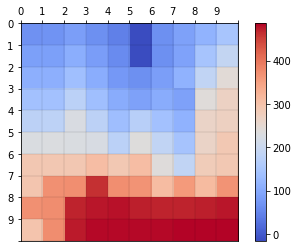

In [44]:
draw_heatmap(V_predicted, save=False, save_file_name="plots/Q21.png")

### Q22

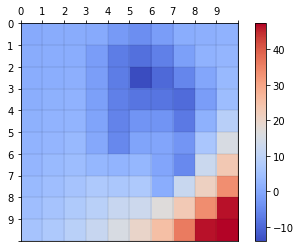

In [45]:
draw_heatmap(V2,save=False,save_file_name="plots/Q22.png")

### Q23

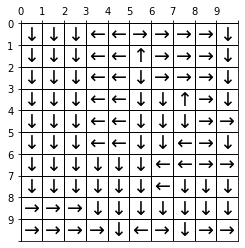

In [46]:
draw_policy_grid(predicted_policy, save=False, save_file_name="plots/Q23.png")

### Q24

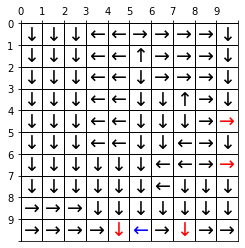

In [47]:
policy_arrows=np.chararray((100,), unicode=True)
col_vec=['k']*100
for s in range(100):
    a=predicted_policy[s]
    if(a==0):
        policy_arrows[s]='↑'
    elif(a==1):
        policy_arrows[s]='→'
    elif(a==2):
        policy_arrows[s]='↓'
    elif(a==3):
        policy_arrows[s]='←'

col_vec[94]='r'
col_vec[96]='r'
col_vec[79]='r'
col_vec[49]='r'
col_vec[59]='b'
col_grid=np.array(col_vec).reshape(10,10)
pa=policy_arrows.reshape(10,10)
board = np.ones((10,10,3))
fig, ax = plt.subplots()
ax.imshow(board, interpolation='nearest', aspect='auto')
ax.grid(color='k', linewidth=1)

for i in range(10):
    for j in range(10):
        ax.text(i, j, pa[i][j], size=19, ha='center', va='center', color=col_grid[i][j])

ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.xaxis.tick_top()
ax.axis('image')

plt.show()
#fig.savefig("plots/Q24_pp.png", dpi=600, bbox_inches='tight')

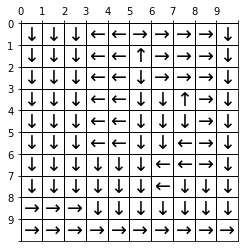

In [48]:
draw_policy_grid(policy2, save=False, save_file_name="plots/Q24.png")

In [49]:
def draw_value_grid(values,save=False,save_file_name=""):
    pa=values.reshape(10,10)
    board = np.ones((10,10,3))
    fig, ax = plt.subplots()
    ax.imshow(board, interpolation='nearest', aspect='auto')
    ax.grid(color='k', linewidth=1)

    for i in range(10):
        for j in range(10):
            ax.text(i, j, np.round(pa[i][j],3), size=5, ha='center', va='center')

    ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
    ax.set_xticklabels(np.arange(0, 10, 1))
    ax.set_yticklabels(np.arange(0, 10, 1))
    ax.xaxis.tick_top()
    ax.axis('image')

    plt.show()
    if save: fig.savefig(save_file_name, dpi=600, bbox_inches='tight')

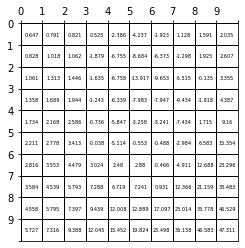

In [50]:
draw_value_grid(V2, save=False, save_file_name="plots/V2.png")

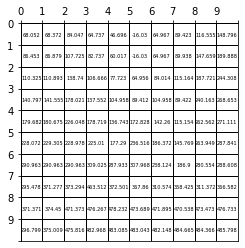

In [51]:
draw_value_grid(V_predicted, save=False, save_file_name="plots/V_predicted.png")

### Q25

In [52]:
V_predicted_modified,predicted_policy_modified=fast_value_iteration(P1,solve_irl(P1,policy2,R2max,lmda_max_2),epsilon=0.001)

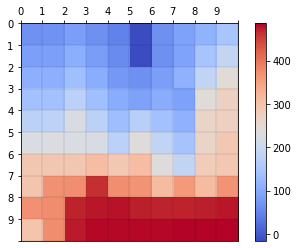

In [53]:
draw_heatmap(V_predicted_modified)

In [54]:
(policy2==predicted_policy_modified).sum()

96

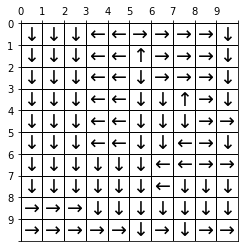

In [55]:
draw_policy_grid(predicted_policy_modified)

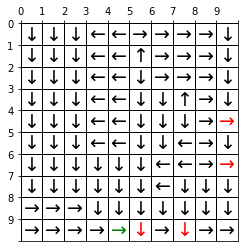

In [56]:
policy_arrows=np.chararray((100,), unicode=True)
col_vec=['k']*100
for s in range(100):
    a=predicted_policy_modified[s]
    if(a==0):
        policy_arrows[s]='↑'
    elif(a==1):
        policy_arrows[s]='→'
    elif(a==2):
        policy_arrows[s]='↓'
    elif(a==3):
        policy_arrows[s]='←'

col_vec[94]='r'
col_vec[96]='r'
col_vec[79]='r'
col_vec[49]='g'
col_vec[59]='r'
col_grid=np.array(col_vec).reshape(10,10)
pa=policy_arrows.reshape(10,10)
board = np.ones((10,10,3))
fig, ax = plt.subplots()
ax.imshow(board, interpolation='nearest', aspect='auto')
ax.grid(color='k', linewidth=1)

for i in range(10):
    for j in range(10):
        ax.text(i, j, pa[i][j], size=19, ha='center', va='center', color=col_grid[i][j])

ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.xaxis.tick_top()
ax.axis('image')

plt.show()
#fig.savefig("plots/Q25_policy_mod.png", dpi=600, bbox_inches='tight')

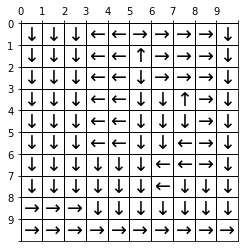

In [57]:
draw_policy_grid(policy2)

In [58]:
lmdas=np.linspace(0,5,500)
accuracy_mod_e=calc_accuracy_over_lmdas(P1,policy2,R2max,lmdas,0.00001)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.10it/s]


Text(0, 0.5, 'Accuracy$=\\sum_{s\\in \\mathcal{S}}\\frac{m(s)}{|\\mathcal{S}|}$')

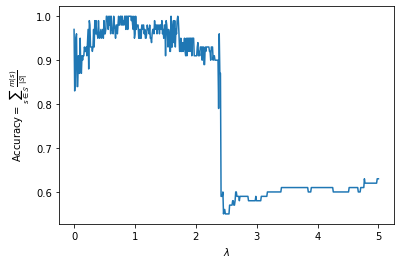

In [59]:
plt.plot(lmdas,accuracy_mod_e)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Accuracy$=\sum_{s\in \mathcal{S}}\frac{m(s)}{|\mathcal{S}|}$')
#plt.savefig('plots/Q25.png', dpi=600, bbox_inches='tight')

In [60]:
print(np.amax(accuracy_mod_e))

1.0


In [61]:
def construct_lp_matrices_modified(P,policy,lmda,Rmax,Rmin,Vmax,Vmin):
    S=np.shape(P)[0]
    c=np.concatenate([gamma*np.ones((S,)), -lmda*np.ones((S,)), np.zeros((S,))])
    A=np.array([])
    nA=4
    
    Pa1=np.zeros((S,S))
    Pas=np.zeros((3,S,S))
    
    for s in range(S):
        opt_a=policy[s]
        Pa1[s,:]=P[s][opt_a]
        other_actions=np.setdiff1d(range(nA), opt_a)
        for i,a in enumerate(other_actions):
            Pas[i,s,:]=P[s][a]
            
    I, Z=np.eye(S), np.zeros((S,S))
    for i in range(nA-1):
        Pa=Pas[i]
        temp=np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))
        temp=np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma*np.array(Pa1)))))))
        if (A.shape[0]==0): A=temp
        else: A=np.vstack((temp, A))
            
    A=np.vstack((A, np.hstack((Z, -I, I))))
    A=np.vstack((A, np.hstack((Z, -I, -I))))
    A=np.vstack((A, np.hstack((Z, Z, I))))
    A=np.vstack((A, np.hstack((Z, Z, -I))))
    A=np.vstack((A, np.hstack((Z, Z, np.linalg.inv(I - gamma*np.array(Pa1))))))
    A=np.vstack((A, np.hstack((Z, Z, -np.linalg.inv(I - gamma*np.array(Pa1))))))
    b=np.concatenate([np.zeros((2*(nA-1)*S+2*S,)), Rmax*np.ones((S,)), Rmax*np.ones((S,)), Vmax*np.ones((S,)), Vmax*np.ones((S,))])
    return [c,A,b]

In [62]:
def solve_irl_modified(P,policy,Rmax,Rmin,Vmax,Vmin,lmda=None):
    if lmda is None: raise NameError("Please specify lambda")
    solvers.options['show_progress']=False
    c,A,b=construct_lp_matrices_modified(P,policy,lmda,Rmax,Rmin,Vmax,Vmin)
    solution=solvers.lp(-matrix(c.transpose()),matrix(A),matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [63]:
R2mx, R2mn=np.amax(R2), np.amin(R2)
V2mx, V2mn=np.amax(V2), np.amin(V2)
V2max = np.amax(np.abs(V2))

In [64]:
R_predicted_mod=solve_irl_modified(P1,policy2,R2max,R2mn,V2max,V2mn,lmda_max_2)

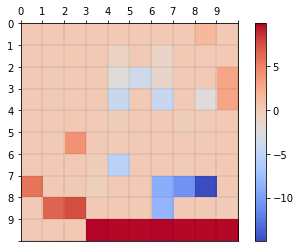

In [65]:
draw_heatmap(R_predicted_mod)

In [66]:
V_predicted_mod,predicted_policy_mod=fast_value_iteration(P1,R_predicted_mod,epsilon=0.001)

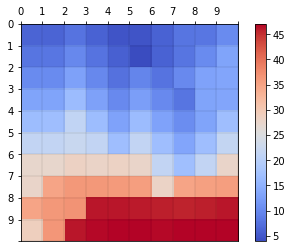

In [67]:
draw_heatmap(V_predicted_mod)

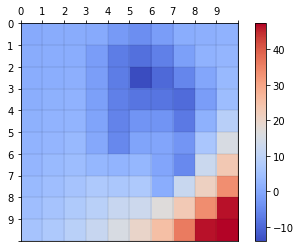

In [68]:
draw_heatmap(V2)

In [69]:
(policy2==predicted_policy_mod).sum()

98

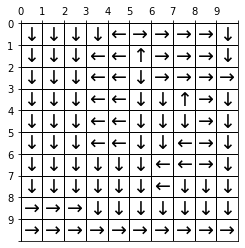

In [70]:
draw_policy_grid(predicted_policy_mod)

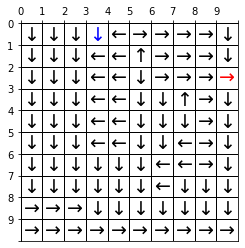

In [71]:
policy_arrows=np.chararray((100,), unicode=True)
col_vec=['k']*100
for s in range(100):
    a=predicted_policy_mod[s]
    if(a==0):
        policy_arrows[s]='↑'
    elif(a==1):
        policy_arrows[s]='→'
    elif(a==2):
        policy_arrows[s]='↓'
    elif(a==3):
        policy_arrows[s]='←'

col_vec[92]='r'
col_vec[30]='b'
col_grid=np.array(col_vec).reshape(10,10)
pa=policy_arrows.reshape(10,10)
board = np.ones((10,10,3))
fig, ax = plt.subplots()
ax.imshow(board, interpolation='nearest', aspect='auto')
ax.grid(color='k', linewidth=1)

for i in range(10):
    for j in range(10):
        ax.text(i, j, pa[i][j], size=19, ha='center', va='center', color=col_grid[i][j])

ax.set(xticks=np.arange(-0.5, 10, 1), yticks=np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.xaxis.tick_top()
ax.axis('image')

plt.show()
#fig.savefig("plots/Q25_policy_mod_new.png", dpi=600, bbox_inches='tight')

In [72]:
def calc_accuracy_over_lmdas_modified(P,target_policy,Rmax,Rmin,Vmax,Vmin,lmdas,epsilon=0.01):
    accuracy=np.zeros_like(lmdas)
    for i,lmda in enumerate(tqdm(lmdas)):
        R_predicted=solve_irl_modified(P,target_policy,Rmax,Rmin,Vmax,Vmin,lmda)
        V,predicted_policy=fast_value_iteration(P,R_predicted,epsilon)
        accuracy[i]=(predicted_policy==target_policy).sum()/100
    return accuracy

In [ ]:
lmdas=np.linspace(0,5,500)
accuracy_modified=calc_accuracy_over_lmdas_modified(P1,policy2,R2max,R2mn,V2max,V2mn,lmdas,epsilon=0.01)

 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [00:20<00:01, 28.72it/s]

In [ ]:
lmdas[np.argmax(accuracy_modified)]

In [ ]:
np.amax(accuracy_modified)

In [ ]:
plt.plot(lmdas,accuracy_modified)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'Accuracy$=\sum_{s\in \mathcal{S}}\frac{m(s)}{|\mathcal{S}|}$')
#plt.savefig('plots/Q25_sweep_mod.png', dpi=600, bbox_inches='tight')